<a href="https://colab.research.google.com/github/darshan-k3/Low-Complexity-Deepfake-Detection-Model/blob/main/TSNE_Visualisation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title 1.0. Download benchmark dataset, clear files from previous runs

# Make sure Google Drive has been mounted
from google.colab import drive
import gdown
# drive.mount('/content/drive', force_remount=True)

import os
# !rm -r benchmark_dataset
if not os.path.isfile('benchmark_dataset.zip'):
  gdown.download('https://drive.google.com/file/d/1E1QwFJeby_bkRFd2SbIWS9-td3SKqNp6/view?usp=sharing', fuzzy=True)

if not os.path.isdir('benchmark_dataset'):
  !unzip benchmark_dataset.zip

# Remove hidden .ipynb checkpoints folder
if os.path.isdir('benchmark_dataset/RealVideo-FakeAudio/.ipynb_checkpoints'):
  !rm -r benchmark_dataset/RealVideo-FakeAudio/.ipynb_checkpoints
  !rm -r benchmark_dataset/FakeVideo-RealAudio/.ipynb_checkpoints

# Remove any preexisting pretrained models
models = ['scaler_audio.pkl', 'scaler_video.pkl', 'svm_model_audio.pkl', 'svm_model_video.pkl',
          'checkpoint.pt', 'mlp_video_model.keras', 'mlp_audio_model.keras']

base_model_dir = 'models'

for model in models:
  model_path = os.path.join(base_model_dir, model)
  if os.path.isfile(model_path):
    !rm -r model_path


if os.path.isdir('temp'):
  !rm -r temp/
os.makedirs('temp', exist_ok=True)

Downloading...
From (original): https://drive.google.com/uc?id=1E1QwFJeby_bkRFd2SbIWS9-td3SKqNp6
From (redirected): https://drive.google.com/uc?id=1E1QwFJeby_bkRFd2SbIWS9-td3SKqNp6&confirm=t&uuid=9d4e4e62-6b06-4922-a86e-0f3eb61fc81b
To: /content/benchmark_dataset.zip
100%|██████████| 206M/206M [00:01<00:00, 114MB/s]


Archive:  benchmark_dataset.zip
   creating: benchmark_dataset/FakeVideo-FakeAudio/
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00018_00181_id00529_wavtolip.mp4  
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00029_00288_id00052_NK_leX996Yk_id00696_wavtolip.mp4  
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00032_00028_1_id07108_wavtolip.mp4  
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00033_00276_id07195_wXqfHGtaBn4_id00032_wavtolip.mp4  
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00049_00118_id00775_yeCUxHgUHxc_id00169_wavtolip.mp4  
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00055_00120_id00415_wavtolip.mp4  
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00063_00021_id00919_XDUn0Pskyrk_id00554_wavtolip.mp4  
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00076_00109_9_id01528_wavtolip.mp4  
  inflating: benchmark_dataset/FakeVideo-FakeAudio/men_id00078_00114_id03599_y27BDmRUqMQ_id07161

In [ ]:
#@title 1.1 Create Testing Dataset (Optional)

# The purpose of this dataset is to debug any problems with the pipeline
# running on larger sets
import shutil
import os
import random

if os.path.isdir('debugging_dataset'):
  !rm -r test_dataset

real_real_dir = os.path.join('benchmark_dataset', 'RealVideo-RealAudio')
real_fake_dir = os.path.join('benchmark_dataset', 'RealVideo-FakeAudio')
fake_real_dir = os.path.join('benchmark_dataset', 'FakeVideo-RealAudio')
fake_fake_dir = os.path.join('benchmark_dataset', 'FakeVideo-FakeAudio')




os.makedirs(os.path.join('debugging_dataset', 'RealVideo-RealAudio'), exist_ok=True)
os.makedirs(os.path.join('debugging_dataset', 'FakeVideo-FakeAudio'), exist_ok=True)
os.makedirs(os.path.join('debugging_dataset', 'FakeVideo-RealAudio'), exist_ok=True)
os.makedirs(os.path.join('debugging_dataset', 'RealVideo-FakeAudio'), exist_ok=True)



test_real_real = random.sample(os.listdir(real_real_dir), 5)

for file in test_real_real:
  shutil.copy(os.path.join(real_real_dir, file), os.path.join('debugging_dataset', 'RealVideo-RealAudio'))

test_real_fake = random.sample(os.listdir(real_fake_dir), 5)

for file in test_real_fake:
  shutil.copy(os.path.join(real_fake_dir, file), os.path.join('debugging_dataset', 'RealVideo-FakeAudio'))

test_fake_real = random.sample(os.listdir(fake_real_dir), 5)

for file in test_fake_real:
  shutil.copy(os.path.join(fake_real_dir, file), os.path.join('debugging_dataset', 'FakeVideo-RealAudio'))

test_fake_fake = random.sample(os.listdir(fake_fake_dir), 5)

for file in test_fake_fake:
  shutil.copy(os.path.join(fake_fake_dir, file), os.path.join('debugging_dataset', 'FakeVideo-FakeAudio'))


In [ ]:
#@title 1.2 Create Train and Test Directories

import os
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path

dataset_dir = Path('benchmark_dataset')

!rm -r test_dataset
!rm -r train_dataset

train_dir = dataset_dir.parent / 'train_dataset'
test_dir = dataset_dir.parent / 'test_dataset'

train_dir.mkdir(parents=True, exist_ok=True)
test_dir.mkdir(parents=True, exist_ok=True)

label_mapping = {
    'RealVideo-RealAudio': 0,
    'RealVideo-FakeAudio': 1,
    'FakeVideo-RealAudio': 1,
    'FakeVideo-FakeAudio': 1,
}

files = []
labels = []

# Collect files and labels
for class_name in label_mapping.keys():
    class_dir = dataset_dir / class_name
    for file in os.listdir(class_dir):
        if file.endswith(".mp4"):  # Assuming you're working with mp4 files
            files.append(class_dir / file)
            labels.append(label_mapping[class_name])

# Test train split
files_train, files_test, _, _ = train_test_split(files, labels, test_size=0.2, random_state=42)


def copy_files(files, destination):
    for file_path in files:
        # Construct the new path in the destination directory
        new_path = destination / file_path.relative_to(dataset_dir)
        new_path.parent.mkdir(parents=True, exist_ok=True)  # Create subdirectories if they don't exist
        shutil.copy(file_path, new_path)  # Copy the file to the new location

copy_files(files_train, train_dir)
copy_files(files_test, test_dir)


rm: cannot remove 'test_dataset': No such file or directory
rm: cannot remove 'train_dataset': No such file or directory


In [ ]:
#@title 2.0. Break test dataset into real dataset
import os
import shutil
from sklearn.model_selection import train_test_split

# Directory where your original folders are located
base_dir = '/content/debugging_dataset'

# Directories for the split datasets
test_dir = 'frames'

# Define your original folders and whether they're real or fake
folders = {
    'RealVideo-RealAudio': 'real',
    'RealVideo-FakeAudio': 'fake',
    'FakeVideo-RealAudio': 'fake',
    'FakeVideo-FakeAudio': 'fake',
}

# Create lists to hold video paths and labels
video_paths = []
labels = []

# Populate lists with video paths and corresponding labels
for folder, label in folders.items():
    folder_path = os.path.join(base_dir, folder)
    for video in os.listdir(folder_path):
        video_paths.append(os.path.join(folder_path, video))
        labels.append(label)

# Function to create directories and copy videos into them
def organise_videos(video_paths, video_labels, directory):
    for path, label in zip(video_paths, video_labels):
        subfolder = os.path.join(directory, label)
        os.makedirs(subfolder, exist_ok=True)
        # Determine new file name (add "_fake" for fake videos)
        file_name = os.path.basename(path)
        destination_path = os.path.join(subfolder, file_name)
        shutil.copy(path, destination_path)

organise_videos(video_paths, labels, test_dir)

In [ ]:
#@title 2.1. Extract and Replace on new dataset
import cv2
import os
import numpy as np

def extract_and_replace_frames(base_dir):
    for category in ['real', 'fake']:  # The two main categories in your folder structure
        category_path = os.path.join(base_dir, category)
        frame_counter = 1  # Initialize frame counter for each category

        for video_name in os.listdir(category_path):
            if not video_name.endswith(('.mp4', '.avi', '.mov')):  # Check if the file is a video
                continue  # Skip non-video files

            video_path = os.path.join(category_path, video_name)
            cap = cv2.VideoCapture(video_path)

            # Check if video opened successfully
            if not cap.isOpened():
                print(f"Error opening video file {video_name}")
                continue

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frames_to_extract = np.linspace(0, total_frames-1, 75, dtype=int)

            for f_id in frames_to_extract:
                cap.set(cv2.CAP_PROP_POS_FRAMES, f_id)
                ret, frame = cap.read()
                if ret:
                    # Save the frame in the category directory with a unique name
                    frame_filename = os.path.join(category_path, f"frame_{frame_counter:03d}.jpg")
                    cv2.imwrite(frame_filename, frame)
                    print('Frame write success')
                    frame_counter += 1
                else:
                    print(f"Error reading frame {f_id} from {video_name}")

            # Release the video capture object and delete the original video
            cap.release()
            os.remove(video_path)
            print(f"Processed and removed {video_name}")

base__test__dir = '/content/xception-frames'

extract_and_replace_frames(base__test__dir)

In [ ]:
#@title 3.0. T-SNE Visualisations
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from skimage.feature import local_binary_pattern
import os
import glob
import librosa
# from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_audio
from moviepy.editor import VideoFileClip
np.random.seed(42)  # For NumPy
random.seed(42)     # For Python's built-in random module

def extract_audio_features(audio_path, n_mfcc=5, n_fft=2048, hop_length=512):
    try:
        audio_data, sr = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        S = librosa.magphase(librosa.stft(audio_data, n_fft=n_fft, hop_length=hop_length, window=np.ones, center=False))[0]
        rms = librosa.feature.rms(S=S, frame_length=n_fft, hop_length=hop_length)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_data, frame_length=n_fft, hop_length=hop_length)


        # Normalise features
        mfcc_norm = normalize(mfccs, norm='l2', axis=1)
        rms_norm = normalize(rms, norm='l2', axis=1)
        zcr_norm = normalize(zero_crossing_rate, norm='l2', axis=1)

        weight_rms = 2.0  # Increase RMS influence
        weight_zcr = 2.0  # Increase ZCR influence

        # Calculate statistical features: mean and standard deviation
        mfcc_mean = np.mean(mfcc_norm, axis=1)
        mfcc_std = np.std(mfcc_norm, axis=1)
        rms_mean = np.mean(rms_norm, axis=1) * weight_rms
        rms_std = np.std(rms_norm, axis=1) * weight_rms
        zcr_mean = np.mean(zcr_norm, axis=1) * weight_zcr
        zcr_std = np.std(zcr_norm, axis=1) * weight_zcr

        # Combine statistical features
        combined_features = np.hstack((mfcc_mean, mfcc_std, rms_mean, rms_std, zcr_mean, zcr_std))
        print(f'Audio Feature shape: {combined_features.shape}')
        return combined_features

    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

def extract_mfcc_features(audio_path, n_mfcc=13, n_fft=2048, hop_length=512, max_frames=50):
    try:
        audio_data, sr = librosa.load(audio_path, sr=None)
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)

        # Normalize features
        mfcc_norm = normalize(mfccs, norm='l2', axis=1)

        # Pad or truncate to max_frames
        if mfcc_norm.shape[1] < max_frames:
            # Pad
            pad_width = max_frames - mfcc_norm.shape[1]
            mfcc_norm = np.pad(mfcc_norm, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate
            mfcc_norm = mfcc_norm[:, :max_frames]

        print(f'Audio Feature shape: {mfcc_norm.shape}')
        return np.mean(mfcc_norm, axis=1)

    except Exception as e:
        print(f"Error processing audio file {audio_path}: {e}")
        return None

def extract_video_features(video_path, is_training=True, sample_count=50, max_attempts=5):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    lbp_histograms = []

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    attempts = 0
    detected = False

    while not detected and attempts < max_attempts:
        frame_indices = np.linspace(0, total_frames - 1, sample_count, dtype=int)

        for frame_index in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if not ret:
                continue

            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.1, 4)

            if len(faces) > 0:
                detected = True  # At least one face was detected

            for (x, y, w, h) in faces:
                face_region = gray[y:y+h, x:x+w]
                lbp = local_binary_pattern(face_region, P=8, R=1, method="uniform")
                (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(257), range=(0, 256))
                lbp_hist = lbp_hist.astype("float")
                lbp_hist /= (lbp_hist.sum() + 1e-7)
                lbp_histograms.append(lbp_hist)

        if not detected:
            print(f"No faces detected on attempt {attempts+1}. Increasing sampling rate.")
            sample_count = int(sample_count * 1.5)  # Increase sampling rate by 50%
            attempts += 1

    cap.release()
    if len(lbp_histograms) > 0:
        print(f'Video Feature shape: {np.array(lbp_histograms).shape}')
        return np.mean(lbp_histograms, axis=0)
    else:
        print("No facial features detected in the video.")
        return None

import os
import glob
import numpy as np
from moviepy.editor import VideoFileClip

def create_features_labels(dataset_path, is_training=True, extract_type='video'):
    X, y = [], []
    categories = {
        'FakeVideo-FakeAudio': 0,
        'RealVideo-FakeAudio': 1,
        'FakeVideo-RealAudio': 2,
        'RealVideo-RealAudio': 3,
    }
    temp_dir = "temp"
    os.makedirs(temp_dir, exist_ok=True)
    for category, label in categories.items():
        video_paths = glob.glob(os.path.join(dataset_path, category, '*.mp4'))
        for video_path in video_paths:
            print(f"Processing {video_path}")
            if extract_type == 'video':
                features = extract_video_features(video_path, is_training)
                if features is not None:
                    X.append(features)
                    y.append(label)  # Use the category-specific label
            else:  # Assuming 'audio' extract_type
                video_name = os.path.basename(video_path)
                audio_output_path = os.path.join(temp_dir, video_name.replace('.mp4', '.wav'))
                if not os.path.isfile(audio_output_path):
                    video_clip = VideoFileClip(video_path)
                    video_clip.audio.write_audiofile(audio_output_path, codec='pcm_s16le')
                    video_clip.close()
                # audio_features = extract_audio_features(audio_output_path)
                audio_features = extract_audio_features(audio_output_path)
                if audio_features is not None:
                    X.append(audio_features)
                    y.append(label)

    return np.array(X), np.array(y)


def visualise_with_tsne(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    X_tsne = tsne.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    colors = ['red', 'green', 'blue', 'purple']
    labels = ['FakeVideo-FakeAudio', 'RealVideo-FakeAudio', 'FakeVideo-RealAudio', 'RealVideo-RealAudio']
    for label, color in zip(range(4), colors):
        indices = [i for i, lbl in enumerate(y) if lbl == label]
        plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=labels[label])
    plt.legend()
    plt.title('T-SNE Visualization of Video Features by Category')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

def main(dataset_path, is_training=True):
    X, y = create_features_labels(dataset_path, is_training)
    visualise_with_tsne(X, y)




In [ ]:
if __name__ == "__main__":
    dataset_path = "test_dataset"
    main(dataset_path)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import random

def visualise_with_tsne_video(X, y):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply T-SNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    X_tsne = tsne.fit_transform(X_scaled)

    # Prepare the plot
    plt.figure(figsize=(10, 6))
    markers = {0: "x", 1: ".", 2: "x", 3: "."}  # Map labels to markers
    colors = ['red', 'green', 'blue', 'purple']  # Colors for each category
    labels = ['FakeVideo-FakeAudio', 'RealVideo-FakeAudio', 'FakeVideo-RealAudio', 'RealVideo-RealAudio']

    # Plot each category with its assigned color and marker
    for label, color in zip(range(4), colors):
        indices = [i for i, lbl in enumerate(y) if lbl == label]  # Get indices for each category
        marker = markers[label]  # Select the marker based on category label
        plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=labels[label], marker=marker)

    # Finalize and show the plot
    plt.legend()
    plt.title('2D T-SNE Visualisation of Video Features by Category')
    plt.show()

def main_video(dataset_path, is_training=True):
    X, y = create_features_labels(dataset_path, is_training, extract_type='video')
    visualise_with_tsne_video(X, y)



Processing test_dataset/FakeVideo-FakeAudio/men_id01098_00044_id01052_Kf4nlIEHfaU_id00520_wavtolip.mp4
Video Feature shape: (50, 256)
Processing test_dataset/FakeVideo-FakeAudio/men_id08457_00417_id00103_qpTVaP4y5DQ_faceswap_id00033_wavtolip.mp4
Video Feature shape: (48, 256)
Processing test_dataset/FakeVideo-FakeAudio/women_id07739_00019_id04144__FJg9YswRzQ_id00363_wavtolip.mp4
Video Feature shape: (58, 256)
Processing test_dataset/FakeVideo-FakeAudio/women_id06065_00160_id05631_xXRQCFAdR-0_id06443_wavtolip.mp4
Video Feature shape: (26, 256)
Processing test_dataset/FakeVideo-FakeAudio/women_id07377_00025_id02310_wavtolip.mp4
Video Feature shape: (47, 256)
Processing test_dataset/FakeVideo-FakeAudio/women_id00235_00052_id00739_wavtolip.mp4
Video Feature shape: (54, 256)
Processing test_dataset/FakeVideo-FakeAudio/women_id06158_00015_id06462_wavtolip.mp4
Video Feature shape: (17, 256)
Processing test_dataset/FakeVideo-FakeAudio/women_id06462_00014_id06060_wavtolip.mp4
Video Feature shap

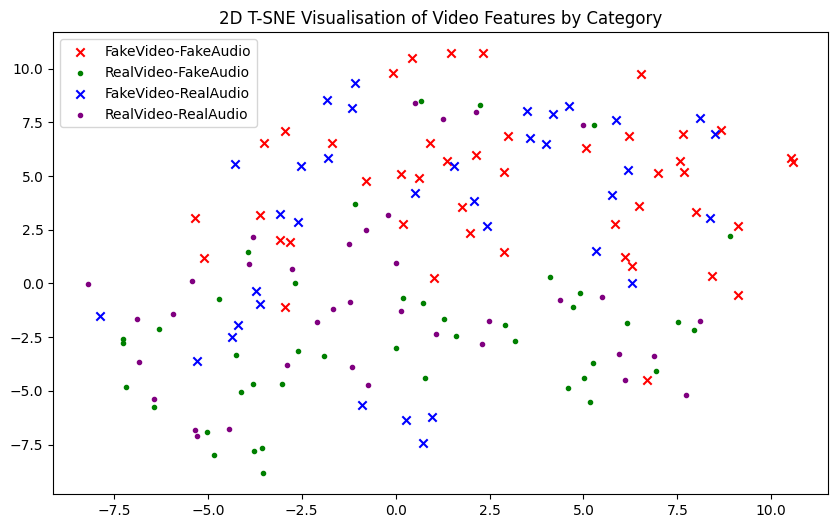

In [ ]:
if __name__ == "__main__":
    dataset_path = "test_dataset"
    main_video(dataset_path)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import numpy as np
import random

def visualise_with_tsne_audio(X, y):
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply T-SNE
    tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
    X_tsne = tsne.fit_transform(X_scaled)

    # Prepare the plot
    plt.figure(figsize=(10, 6))
    markers = {0: "x", 1: "x", 2: ".", 3: "."}
    colors = ['red', 'blue', 'green', 'purple']
    labels = ['FakeVideo-FakeAudio', 'RealVideo-FakeAudio', 'FakeVideo-RealAudio', 'RealVideo-RealAudio']

    # Plot each category with its assigned color and marker
    for label, color in zip(range(4), colors):
        indices = [i for i, lbl in enumerate(y) if lbl == label]
        marker = markers[label]
        plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=labels[label], marker=marker)

    # Finalise and show the plot
    plt.legend()
    plt.title('2D T-SNE Visualisation of Audio Features ')
    plt.show()

def main_audio(dataset_path, is_training=True):
    X, y = create_features_labels(dataset_path, is_training, extract_type='audio')
    visualise_with_tsne_audio(X, y)



Processing test_dataset/FakeVideo-FakeAudio/men_id01098_00044_id01052_Kf4nlIEHfaU_id00520_wavtolip.mp4
Audio Feature shape: (14,)
Processing test_dataset/FakeVideo-FakeAudio/men_id08457_00417_id00103_qpTVaP4y5DQ_faceswap_id00033_wavtolip.mp4
Audio Feature shape: (14,)
Processing test_dataset/FakeVideo-FakeAudio/women_id07739_00019_id04144__FJg9YswRzQ_id00363_wavtolip.mp4
Audio Feature shape: (14,)
Processing test_dataset/FakeVideo-FakeAudio/women_id06065_00160_id05631_xXRQCFAdR-0_id06443_wavtolip.mp4
Audio Feature shape: (14,)
Processing test_dataset/FakeVideo-FakeAudio/women_id07377_00025_id02310_wavtolip.mp4
Audio Feature shape: (14,)
Processing test_dataset/FakeVideo-FakeAudio/women_id00235_00052_id00739_wavtolip.mp4
Audio Feature shape: (14,)
Processing test_dataset/FakeVideo-FakeAudio/women_id06158_00015_id06462_wavtolip.mp4
Audio Feature shape: (14,)
Processing test_dataset/FakeVideo-FakeAudio/women_id06462_00014_id06060_wavtolip.mp4
Audio Feature shape: (14,)
Processing test_dat

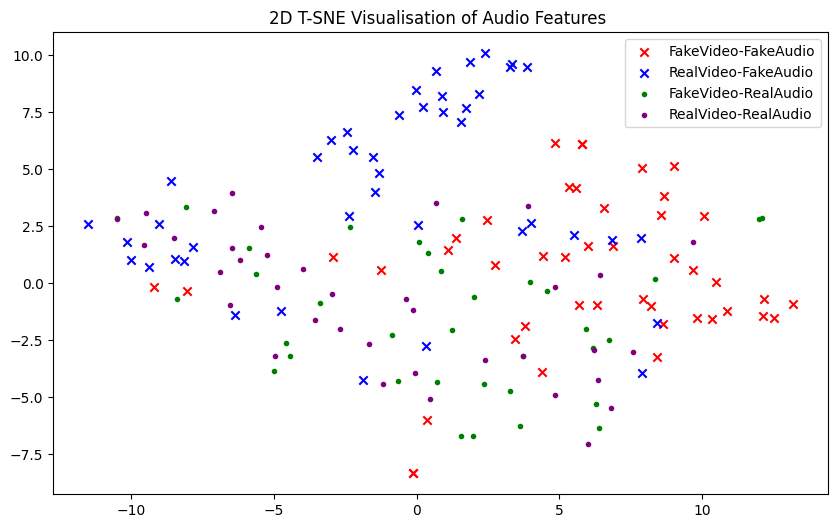

In [ ]:
if __name__ == "__main__":
    dataset_path = "test_dataset"
    main_audio(dataset_path)